In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import kaggle_data_utils
import summarize_kaggle

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn import decomposition
import pandas as pd

In [ ]:
season_games = summarize_kaggle.load_regular_games(relative_path='..')
season_games.head()

In [ ]:
game_scores = season_games[['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore']]
game_scores.head()

In [ ]:
SEASON = 2022
season_df = game_scores[game_scores.Season == SEASON]
season_df.head()

In [ ]:
teams = set(season_df.WTeamID.unique()).union(set(season_df.LTeamID.unique()))
team_map = {team_id: i for i, team_id in enumerate(teams)}
print(len(team_map))

In [ ]:
# The warning is ok here because we want season_df to be a copy
season_df['WIdx'] = season_df.WTeamID.apply(team_map.get)
season_df['LIdx'] = season_df.LTeamID.apply(team_map.get)
season_df.head()

In [ ]:
season_df_avg = season_df.groupby(['Season', 'WIdx', 'LIdx']).mean()[['WScore', 'LScore']].reset_index()
season_df_avg.head()

In [ ]:
Wdata = season_df_avg[['WScore', 'WIdx', 'LIdx']].values
Ldata = season_df_avg[['LScore', 'LIdx', 'WIdx']].values

vals = np.concatenate((Wdata[:, 0], Ldata[:, 0]))
rows = np.concatenate((Wdata[:, 1], Ldata[:, 1]))
cols = np.concatenate((Wdata[:, 2], Ldata[:, 2]))

score_matrix = sparse.coo_matrix((vals, (rows.astype(int), cols.astype(int))))
score_matrix.nnz, score_matrix.shape

In [ ]:
score_matrix.toarray()[0, 355], season_df[(season_df['WIdx'] == 0) & (season_df['LIdx'] == 355)]

In [ ]:
N_FEATURES = 20
nmf = decomposition.NMF(n_components=N_FEATURES, random_state=42, max_iter=1000)
attacker_matrix = nmf.fit_transform(score_matrix.toarray())
defender_matrix = nmf.components_
attacker_matrix.shape, defender_matrix.shape

In [ ]:
nmf.reconstruction_err_, nmf.n_iter_

In [ ]:
np.sqrt(np.mean((score_matrix.toarray() - attacker_matrix @ defender_matrix) ** 2))

In [ ]:
diff_array = (score_matrix.toarray() - attacker_matrix @ defender_matrix).flatten()
plt.hist(diff_array)

In [ ]:
stats_matrix = np.concatenate((attacker_matrix, defender_matrix.T), axis=1)
stats_matrix.shape

In [ ]:
nmf_stats_df = pd.DataFrame(stats_matrix)
nmf_stats_df.head()

In [ ]:
tournament_df = pd.read_csv('../data/kaggle_data/MNCAATourneyCompactResults.csv')
tournament_df.head()

In [ ]:
tournament_df['WIdx'] = tournament_df.WTeamID.apply(team_map.get)
tournament_df['LIdx'] = tournament_df.LTeamID.apply(team_map.get)
tournament_df.head()

In [ ]:
season_tourney = tournament_df[tournament_df.Season == SEASON]
season_tourney.head()

In [ ]:
season_tourney = season_tourney.join(nmf_stats_df, on='WIdx')
season_tourney = season_tourney.join(nmf_stats_df, on='LIdx', lsuffix='_Wfeat', rsuffix='_Lfeat')
season_tourney.head()

In [ ]:
w_attack_col = [f'{i}_Wfeat' for i in range(N_FEATURES)]
w_defend_col = [f'{i}_Wfeat' for i in range(N_FEATURES, 2 * N_FEATURES)]
l_attack_col = [f'{i}_Lfeat' for i in range(N_FEATURES)]
l_defend_col = [f'{i}_Lfeat' for i in range(N_FEATURES, 2 * N_FEATURES)]

season_tourney['WScore_pred'] = np.diag(season_tourney[w_attack_col].values @ season_tourney[l_defend_col].values.T)
season_tourney['LScore_pred'] = np.diag(season_tourney[l_attack_col].values @ season_tourney[w_defend_col].values.T)

In [ ]:
rms_error = np.sqrt(np.mean((season_tourney.WScore - season_tourney.WScore_pred) ** 2) + 
                    np.mean((season_tourney.LScore - season_tourney.LScore_pred) ** 2))
rms_error

In [ ]:
season_tourney[['WScore', 'WScore_pred']].head(10)

In [ ]:
season_tourney[['LScore', 'LScore_pred']].head(10)

In [ ]:
season_tourney['Correct'] = season_tourney.WScore_pred > season_tourney.LScore_pred

In [ ]:
season_tourney['Correct'].sum() / len(season_tourney)

In [ ]:
tournament_df = pd.read_csv('../data/kaggle_data/MNCAATourneyCompactResults.csv')

scores = []
for num_components in [2, 5, 10, 15, 20, 50, 75, 100]:
    clf_score = []
    for season in game_scores.Season.unique():
        season_df = game_scores[game_scores.Season == season]
        teams = set(season_df.WTeamID.unique()).union(set(season_df.LTeamID.unique()))
        team_map = {team_id: i for i, team_id in enumerate(teams)}

        # The warning is ok here because we want season_df to be a copy
        season_df['WIdx'] = season_df.WTeamID.apply(team_map.get)
        season_df['LIdx'] = season_df.LTeamID.apply(team_map.get)
        tournament_df['WIdx'] = tournament_df.WTeamID.apply(team_map.get)
        tournament_df['LIdx'] = tournament_df.LTeamID.apply(team_map.get)

        season_df_avg = season_df.groupby(['Season', 'WIdx', 'LIdx']).mean()[['WScore', 'LScore']].reset_index()
        Wdata = season_df_avg[['WScore', 'WIdx', 'LIdx']].values
        Ldata = season_df_avg[['LScore', 'LIdx', 'WIdx']].values

        vals = np.concatenate((Wdata[:, 0], Ldata[:, 0]))
        rows = np.concatenate((Wdata[:, 1], Ldata[:, 1]))
        cols = np.concatenate((Wdata[:, 2], Ldata[:, 2]))

        score_matrix = sparse.coo_matrix((vals, (rows.astype(int), cols.astype(int))))

        nmf = decomposition.NMF(n_components=num_components, random_state=42, max_iter=1000)
        attacker_matrix = nmf.fit_transform(score_matrix.toarray())
        defender_matrix = nmf.components_
        
        stats_matrix = np.concatenate((attacker_matrix, defender_matrix.T), axis=1)
        nmf_stats_df = pd.DataFrame(stats_matrix)
        
        season_tourney = tournament_df[tournament_df.Season == season]
        season_tourney = season_tourney.join(nmf_stats_df, on='WIdx')
        season_tourney = season_tourney.join(nmf_stats_df, on='LIdx', lsuffix='_Wfeat', rsuffix='_Lfeat')
        if len(season_tourney) == 0:
            continue
        
        w_attack_col = [f'{i}_Wfeat' for i in range(num_components)]
        w_defend_col = [f'{i}_Wfeat' for i in range(num_components, 2 * num_components)]
        l_attack_col = [f'{i}_Lfeat' for i in range(num_components)]
        l_defend_col = [f'{i}_Lfeat' for i in range(num_components, 2 * num_components)]

        season_tourney['WScore_pred'] = np.diag(season_tourney[w_attack_col].values @ season_tourney[l_defend_col].values.T)
        season_tourney['LScore_pred'] = np.diag(season_tourney[l_attack_col].values @ season_tourney[w_defend_col].values.T)
        
        season_tourney['Correct'] = season_tourney.WScore_pred > season_tourney.LScore_pred
        clf_score.append(season_tourney['Correct'].sum() / len(season_tourney))
        
    scores.append(np.mean(clf_score))

In [ ]:
plt.plot(scores)
plt.show()

In [ ]:
scores

In [ ]:
clf_score = []
num_components = 1
for season in game_scores.Season.unique():
    season_df = game_scores[game_scores.Season == season]
    teams = set(season_df.WTeamID.unique()).union(set(season_df.LTeamID.unique()))
    team_map = {team_id: i for i, team_id in enumerate(teams)}

    # The warning is ok here because we want season_df to be a copy
    season_df['WIdx'] = season_df.WTeamID.apply(team_map.get)
    season_df['LIdx'] = season_df.LTeamID.apply(team_map.get)
    tournament_df['WIdx'] = tournament_df.WTeamID.apply(team_map.get)
    tournament_df['LIdx'] = tournament_df.LTeamID.apply(team_map.get)

    season_df_avg = season_df.groupby(['Season', 'WIdx', 'LIdx']).mean()[['WScore', 'LScore']].reset_index()
    Wdata = season_df_avg[['WScore', 'WIdx', 'LIdx']].values
    Ldata = season_df_avg[['LScore', 'LIdx', 'WIdx']].values

    vals = np.concatenate((Wdata[:, 0], Ldata[:, 0]))
    rows = np.concatenate((Wdata[:, 1], Ldata[:, 1]))
    cols = np.concatenate((Wdata[:, 2], Ldata[:, 2]))

    score_matrix = sparse.coo_matrix((vals, (rows.astype(int), cols.astype(int))))

    nmf = decomposition.NMF(n_components=num_components, random_state=42, max_iter=1000)
    attacker_matrix = nmf.fit_transform(score_matrix.toarray())
    defender_matrix = nmf.components_

    stats_matrix = np.concatenate((attacker_matrix, defender_matrix.T), axis=1)
    nmf_stats_df = pd.DataFrame(stats_matrix)

    season_tourney = tournament_df[tournament_df.Season == season]
    season_tourney = season_tourney.join(nmf_stats_df, on='WIdx')
    season_tourney = season_tourney.join(nmf_stats_df, on='LIdx', lsuffix='_Wfeat', rsuffix='_Lfeat')
    if len(season_tourney) == 0:
        continue

    w_attack_col = [f'{i}_Wfeat' for i in range(num_components)]
    w_defend_col = [f'{i}_Wfeat' for i in range(num_components, 2 * num_components)]
    l_attack_col = [f'{i}_Lfeat' for i in range(num_components)]
    l_defend_col = [f'{i}_Lfeat' for i in range(num_components, 2 * num_components)]

    season_tourney['WScore_pred'] = np.diag(season_tourney[w_attack_col].values @ season_tourney[l_defend_col].values.T)
    season_tourney['LScore_pred'] = np.diag(season_tourney[l_attack_col].values @ season_tourney[w_defend_col].values.T)

    season_tourney['Correct'] = season_tourney.WScore_pred > season_tourney.LScore_pred
    clf_score.append(season_tourney['Correct'].sum() / len(season_tourney))

In [ ]:
np.mean(clf_score)

# CVX

In [43]:
import cvxpy as cp
import numpy as np

import kaggle_data_utils
import summarize_kaggle

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn import decomposition
import pandas as pd
from tqdm import tqdm

In [44]:
season_games = summarize_kaggle.load_regular_games(relative_path='..')
game_scores = season_games[['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore']]
SEASON = 2022
season_df = game_scores[game_scores.Season == SEASON]
teams = set(season_df.WTeamID.unique()).union(set(season_df.LTeamID.unique()))
team_map = {team_id: i for i, team_id in enumerate(teams)}
# The warning is ok here because we want season_df to be a copy
season_df['WIdx'] = season_df.WTeamID.apply(team_map.get)
season_df['LIdx'] = season_df.LTeamID.apply(team_map.get)
season_df_avg = season_df.groupby(['Season', 'WIdx', 'LIdx']).mean()[['WScore', 'LScore']].reset_index()
Wdata = season_df_avg[['WScore', 'WIdx', 'LIdx']].values
Ldata = season_df_avg[['LScore', 'LIdx', 'WIdx']].values

vals = np.concatenate((Wdata[:, 0], Ldata[:, 0]))
rows = np.concatenate((Wdata[:, 1], Ldata[:, 1]))
cols = np.concatenate((Wdata[:, 2], Ldata[:, 2]))
data_mean = np.mean(vals)

score_matrix = sparse.coo_matrix((vals - data_mean, (rows.astype(int), cols.astype(int))))
score_matrix = score_matrix.toarray()

/var/folders/kk/5t8h1v2j3ylgl25dskhdcp3c0000gn/T/ipykernel_71336/859621318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_df['WIdx'] = season_df.WTeamID.apply(team_map.get)
/var/folders/kk/5t8h1v2j3ylgl25dskhdcp3c0000gn/T/ipykernel_71336/859621318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_df['LIdx'] = season_df.LTeamID.apply(team_map.get)


In [45]:
m, n = score_matrix.shape
k = 5
Y_init = np.ones(shape=(m, k))

In [46]:
# Ensure same initial random Y, rather than generate new one
# when executing this cell.
Y = Y_init

# Perform alternating minimization.
MAX_ITERS = 100
residual = np.zeros(MAX_ITERS)
for iter_num in tqdm(range(1, 1+MAX_ITERS)):
    # At the beginning of an iteration, X and Y are NumPy
    # array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        X = cp.Variable(shape=(k, n))
        #constraint = [X >= 0]
    # For even iterations, treat X constant, optimize over Y.
    else:
        Y = cp.Variable(shape=(m, k))
        #constraint = [Y >= 0]

    # Solve the problem.
    # increase max iters otherwise, a few iterations are "OPTIMAL_INACCURATE"
    # (eg a few of the entries in X or Y are negative beyond standard tolerances)
    obj = cp.Minimize(cp.norm(score_matrix - (Y@X), 'fro'))
    prob = cp.Problem(obj, constraint)
    prob.solve(solver=cp.SCS, max_iters=10000)

    if prob.status != cp.OPTIMAL:
        raise Exception("Solver did not converge!")

    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        X = X.value
    else:
        Y = Y.value

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


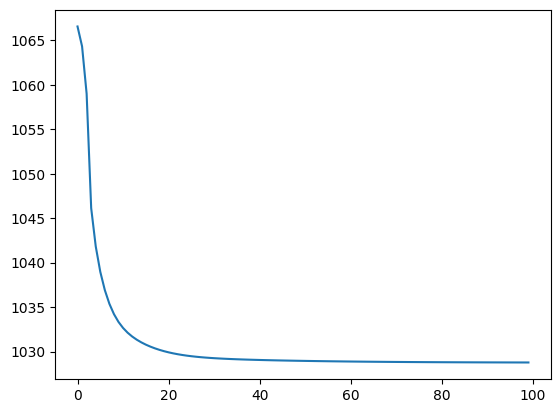

In [47]:
plt.plot(residual)
plt.show()

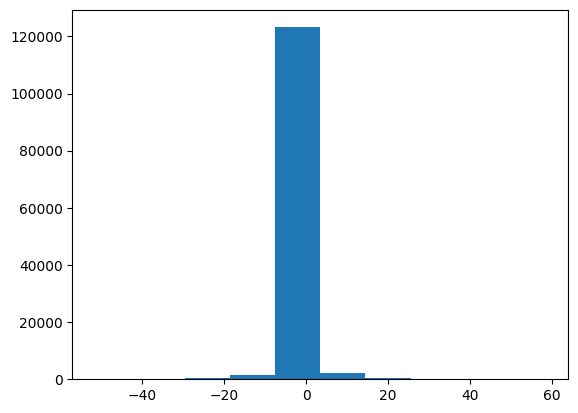

In [48]:
diff_array = (score_matrix - Y @ X).flatten()
plt.hist(diff_array)
plt.show()

In [49]:
np.mean(diff_array)

-0.03519878538463463

In [50]:
stats_matrix = np.concatenate((Y, X.T), axis=1)
nmf_stats_df = pd.DataFrame(stats_matrix)
nmf_stats_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.711690,1.213532,-1.636006,0.495373,2.638508,0.644132,-0.150563,-0.142894,-0.136884,-0.143819
1,0.057248,-4.767400,13.055444,-8.104743,0.682128,0.590057,-0.194983,-0.209911,-0.155800,-0.190488
2,0.140912,-1.474113,1.628212,-0.801469,1.077323,-0.637405,0.109708,0.133680,0.149238,0.127578
3,-1.045505,5.976271,-21.234234,13.435839,-1.386509,1.247538,-0.264722,-0.191105,-0.158970,-0.126503
4,-0.655557,17.921870,2.873967,-14.311308,-8.906546,2.146873,-0.547321,-0.600481,-0.530216,-0.526996


In [51]:
tournament_df = pd.read_csv('../data/kaggle_data/MNCAATourneyCompactResults.csv')
tournament_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [52]:
tournament_df['WIdx'] = tournament_df.WTeamID.apply(team_map.get)
tournament_df['LIdx'] = tournament_df.LTeamID.apply(team_map.get)
tournament_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WIdx,LIdx
0,1985,136,1116,63,1234,54,N,0,14,126
1,1985,136,1120,59,1345,58,N,0,17,234
2,1985,136,1207,68,1250,43,N,0,100,142
3,1985,136,1229,58,1425,55,N,0,121,313
4,1985,136,1242,49,1325,38,N,0,134,215


In [53]:
season_tourney = tournament_df[tournament_df.Season == SEASON]
season_tourney = season_tourney.join(nmf_stats_df, on='WIdx')
season_tourney = season_tourney.join(nmf_stats_df, on='LIdx', lsuffix='_Wfeat', rsuffix='_Lfeat')
season_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WIdx,LIdx,...,0_Lfeat,1_Lfeat,2_Lfeat,3_Lfeat,4_Lfeat,5_Lfeat,6_Lfeat,7_Lfeat,8_Lfeat,9_Lfeat
2317,2022,134,1231,66,1461,58,N,0,123,346,...,1.160634,1.190616,2.323628,-2.720124,4.198467,0.849071,-0.341326,-0.380709,-0.271757,-0.280740
2318,2022,134,1411,76,1394,67,N,0,299,282,...,2.188907,0.651707,2.382572,3.717376,1.658958,1.424963,-0.269733,-0.286110,-0.269770,-0.289634
2319,2022,135,1323,89,1353,87,N,2,213,242,...,-0.005220,-2.453272,4.038108,-4.834077,2.969918,-3.249771,0.777661,0.788640,0.847422,0.797242
2320,2022,135,1460,93,1136,82,N,0,345,30,...,1.186474,-2.691572,3.387574,-0.009971,3.764025,-0.031168,0.012594,0.067382,0.078360,0.052969
2321,2022,136,1116,75,1436,71,N,0,14,323,...,-0.222932,-6.225577,4.685228,1.934969,-1.118650,-0.426533,0.095809,0.078950,0.112274,0.096673


In [54]:
w_attack_col = [f'{i}_Wfeat' for i in range(k)]
w_defend_col = [f'{i}_Wfeat' for i in range(k, 2 * k)]
l_attack_col = [f'{i}_Lfeat' for i in range(k)]
l_defend_col = [f'{i}_Lfeat' for i in range(k, 2 * k)]

season_tourney['WScore_pred'] = np.diag(season_tourney[w_attack_col].values @ season_tourney[l_defend_col].values.T) + data_mean
season_tourney['LScore_pred'] = np.diag(season_tourney[l_attack_col].values @ season_tourney[w_defend_col].values.T) + data_mean

In [55]:
rms_error = np.sqrt(np.mean((season_tourney.WScore - season_tourney.WScore_pred) ** 2) + 
                    np.mean((season_tourney.LScore - season_tourney.LScore_pred) ** 2))
rms_error

17.361811547153994

In [58]:
season_tourney[['WScore', 'WScore_pred', 'LScore', 'LScore_pred']].head(10)

,WScore,WScore_pred,LScore,LScore_pred
2317,66,69.959215,58,69.876564
2318,76,70.121652,67,70.356561
2319,89,70.463220,87,70.213652
2320,93,69.705722,82,69.986551
2321,75,70.150587,71,69.767144
2322,85,69.908747,49,70.337417
2323,72,69.074848,69,70.082630
2324,93,69.913899,72,69.580091
2325,83,71.041032,56,69.692146
2326,64,69.962675,53,69.922213


In [57]:
season_tourney['Correct'] = season_tourney.WScore_pred > season_tourney.LScore_pred
season_tourney['Correct'].sum() / len(season_tourney)

0.5522388059701493